In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
df = pd.read_csv("../data/processed/data_final.csv")

In [4]:
# Quantile berechnen
q25 = df["mean_hrv"].quantile(0.25)
q75 = df["mean_hrv"].quantile(0.75)
print(q25, q75)

35.22416136363636 43.46316861111111


In [5]:
# Binäre Zielvariable
df_bin = df[(df["mean_hrv"] <= q25) | (df["mean_hrv"] >= q75)].copy()
df_bin["low_hrv"] = (df_bin["mean_hrv"] <= q25).astype(int)

In [6]:
df_bin

,date,sleepCore,sleepDeep,sleepREM,sleepUnspecified,awake,sleep_sum,sleep_sum_hours,sleep_efficiency,deep_rem_ratio,deep_rem_score,sleep_quality,mean_hrv,stepCount,sportTime,low_hrv
2,2022-10-06,226.5,76.0,108.0,0.0,10.0,420.5,7.008333,0.976219,0.448234,0.827446,91.670975,46.271080,12526,45.0,0
3,2022-10-08,403.0,44.5,147.5,0.0,26.5,621.5,10.358333,0.957361,0.322689,0.408964,73.800217,43.618358,3911,1.0,0
4,2022-10-09,371.5,36.5,126.5,0.0,7.0,541.5,9.025000,0.987073,0.304958,0.349860,73.218764,57.311775,8104,15.0,0
5,2022-10-10,341.0,35.0,137.5,0.0,5.5,519.0,8.650000,0.989403,0.335930,0.453100,77.488148,49.602583,8191,20.0,0
6,2022-10-11,327.5,47.0,101.5,0.0,4.5,480.5,8.008333,0.990635,0.311975,0.373249,74.368057,32.091150,11237,43.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2025-11-12,302.5,45.0,119.5,0.0,3.5,470.5,7.841667,0.992561,0.352248,0.507495,79.853452,50.065575,11556,40.0,0
746,2025-11-14,286.0,38.0,110.5,0.0,2.5,437.0,7.283333,0.994279,0.341772,0.472574,78.559704,50.871845,13000,58.0,0
748,2025-11-16,249.0,42.5,100.0,0.0,6.5,398.0,6.633333,0.983668,0.363985,0.546616,80.884724,51.250550,11345,19.0,0
750,2025-11-18,246.0,42.5,115.0,0.0,3.0,406.5,6.775000,0.992620,0.390335,0.634449,84.935139,49.071225,21517,91.0,0


In [7]:
# Features & Target
X = df_bin[["sleep_sum", "sleep_quality", "stepCount", "sportTime"]]
y = df_bin["low_hrv"]

In [8]:
# Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Pipeline (wichtig!)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])


In [10]:
pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [11]:
# Evaluation
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

In [12]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66        38
           1       0.66      0.55      0.60        38

    accuracy                           0.63        76
   macro avg       0.63      0.63      0.63        76
weighted avg       0.63      0.63      0.63        76

ROC-AUC: 0.6620498614958448


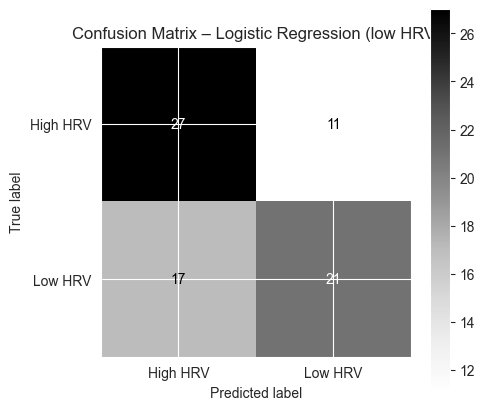

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["High HRV", "Low HRV"]
)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Grays')
plt.title("Confusion Matrix – Logistic Regression (low HRV)")
plt.show()